In [1]:
%pylab inline
import numpy as np
import torch
import os

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from skimage.transform import resize
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_VAEGAN import *
from Model_alphaWGAN import Discriminator as alpha_D
from utils import *
from utils import sinkhorn_pointcloud as sp

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE=4
max_epoch = 100
gpu = True
workers = 4

reg = 5e-10

gamma = 20
beta = 10

Use_BRATS=False
Use_ATLAS = False

#setting latent variable sizes
latent_dim = 1000

gpu_0 = 2
torch_seed = 4
r_g = torch.manual_seed(torch_seed)

In [3]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
# if Use_BRATS:
#     #'flair' or 't2' or 't1ce'
#     trainset = BRATSdataset(imgtype='flair')
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)
# if Use_ATLAS:
#     trainset = ATLASdataset(augmentation=True)
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

In [4]:
G = Generator(noise = latent_dim)
D = Discriminator()
E = Encoder(gpu_ind=gpu_0)
# E = alpha_D(out_class = latent_dim, is_dis=False)

G.cuda(gpu_0)
D.cuda(gpu_0)
E.cuda(gpu_0)

Encoder(
  (conv1): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn4): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mean): Sequential(
    (0): Linear(in_features=32768, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=1000, bias=True)
  )
  (logvar): Sequential(
    (0): Linear(in_features=32768, out_features=2048, bias=True)
    (1): BatchNorm1d(2

In [5]:
g_optimizer = optim.Adam(G.parameters(), lr=0.0001)
d_optimizer = optim.Adam(D.parameters(), lr=0.0001)
e_optimizer = optim.Adam(E.parameters(), lr=0.0001)

# Training

In [6]:
N_EPOCH = 300

criterion_bce = nn.BCELoss()
criterion_l1 = nn.L1Loss()
d_iter = 1

pth = 'vae_checkpoint'
# load the highest savepoints of all models
df = load_loss(f'./{pth}/loss.csv')
init_epoch = vae_load_checkpoint(G, D, E, checkpoint_name=pth)
gen_load = inf_train_gen(train_loader)

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[3/300] D: -1.0     En: 0.14     De: 1.24    


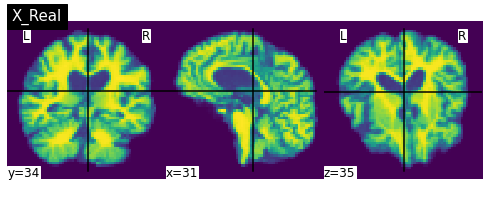

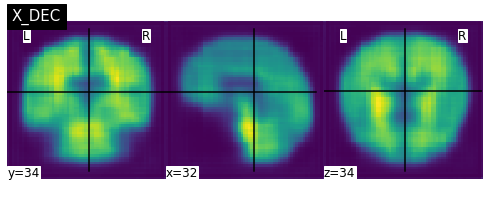

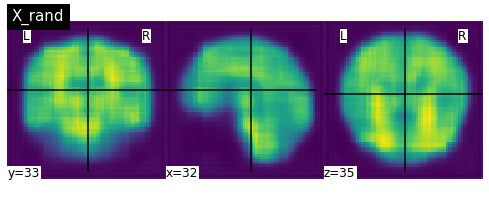

G loss: 0.13629849255084991


<Figure size 432x288 with 0 Axes>

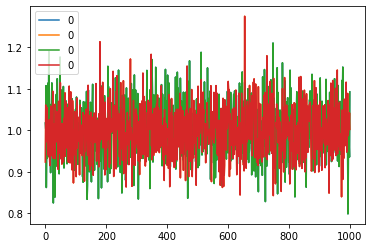

index: 3, sample_mean: 0.0045921835117042065 sample_var: 1.010063886642456, yellow_mean: -0.002080285456031561 yellow_var: 1.0001254081726074


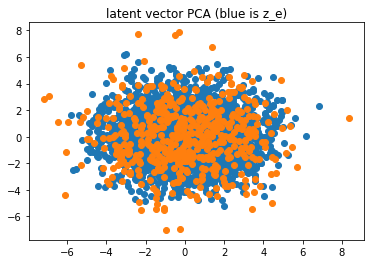

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 3, sample_mean: -0.8822512626647949 sample_var: 0.030881773680448532, yellow_mean: -0.8590792417526245 yellow_var: 0.05627135932445526


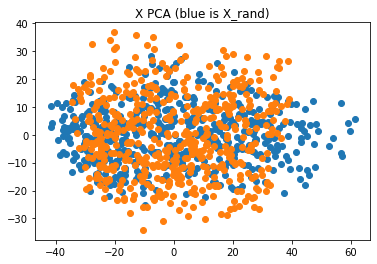

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[4/300] D: 2.4e-09  En: 0.0961   De: 0.168   


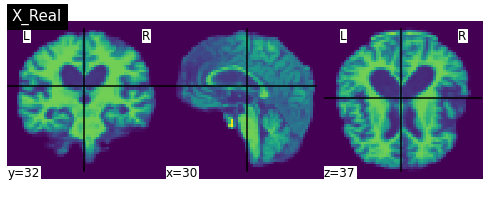

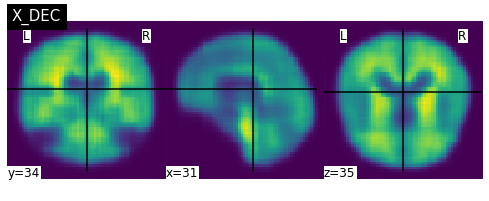

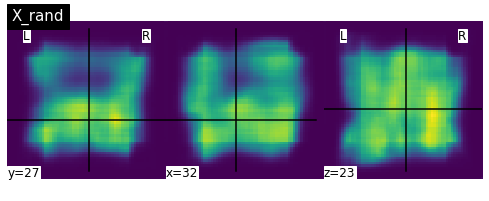

G loss: 0.1536506712436676


<Figure size 432x288 with 0 Axes>

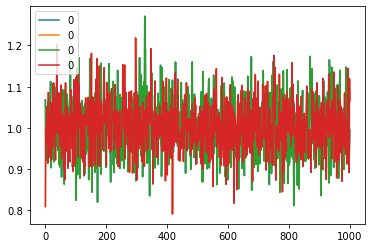

index: 4, sample_mean: 0.004094401374459267 sample_var: 1.0118703842163086, yellow_mean: 0.0002482570707798004 yellow_var: 1.002897024154663


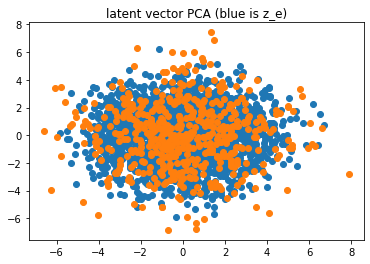

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 4, sample_mean: -0.8652624487876892 sample_var: 0.041633240878582, yellow_mean: -0.8597187995910645 yellow_var: 0.055540379136800766


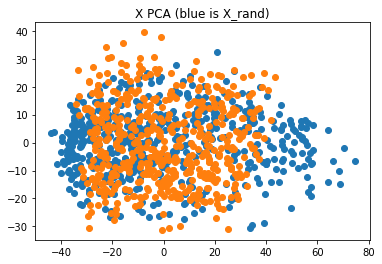

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[5/300] D: 3.02e-09 En: 0.0849   De: 0.151   


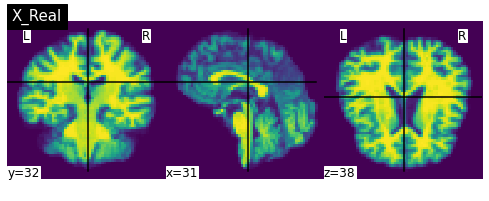

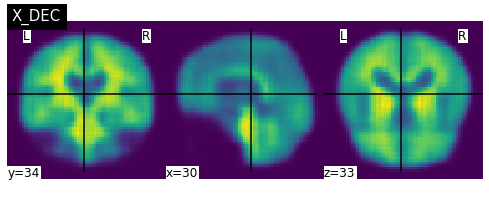

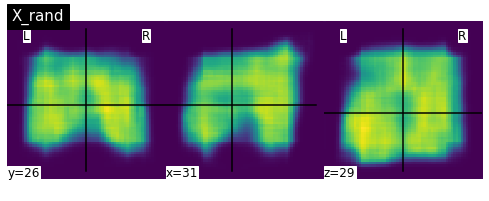

G loss: 0.1993744820356369


<Figure size 432x288 with 0 Axes>

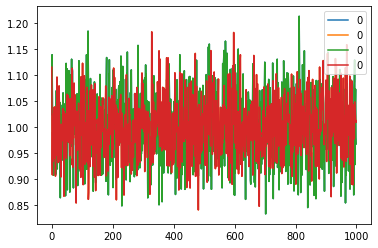

index: 5, sample_mean: 0.0024154207203537226 sample_var: 1.0093162059783936, yellow_mean: -0.0014483045088127255 yellow_var: 0.9990628957748413


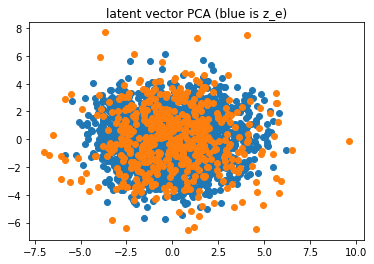

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 5, sample_mean: -0.8613705635070801 sample_var: 0.04593963921070099, yellow_mean: -0.8599421381950378 yellow_var: 0.05574342980980873


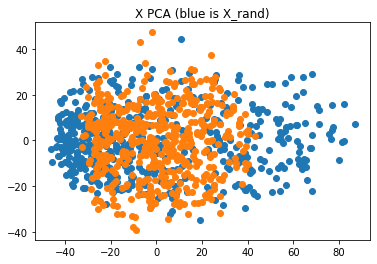

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[6/300] D: 7.24e-10 En: 0.141    De: 0.261   


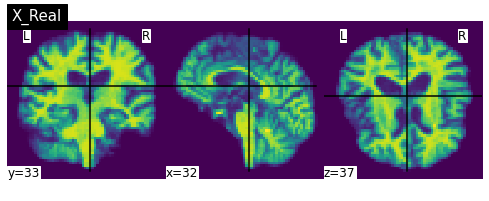

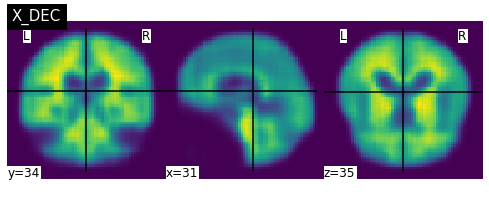

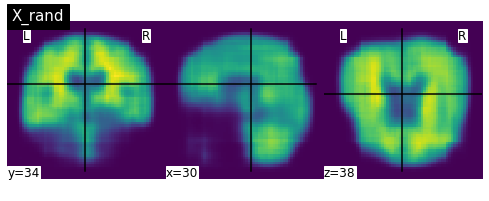

G loss: 0.1624699831008911


<Figure size 432x288 with 0 Axes>

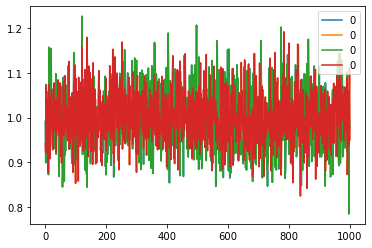

index: 6, sample_mean: 0.005408929660916328 sample_var: 1.0121934413909912, yellow_mean: -0.00045371713349595666 yellow_var: 0.9992210865020752


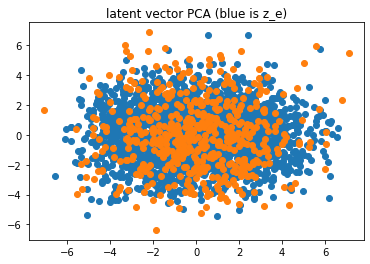

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 6, sample_mean: -0.8795828819274902 sample_var: 0.03452085703611374, yellow_mean: -0.8584363460540771 yellow_var: 0.05682208389043808


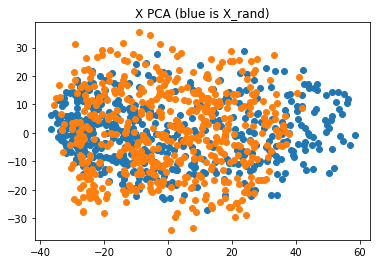

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[7/300] D: 3.49e-10 En: 0.0944   De: 0.165   


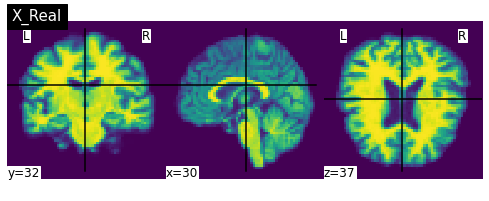

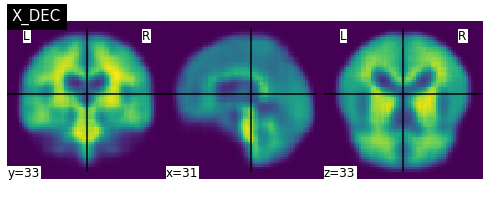

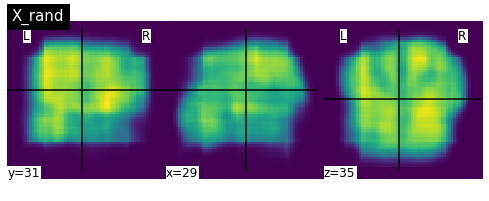

G loss: 0.20164869725704193


<Figure size 432x288 with 0 Axes>

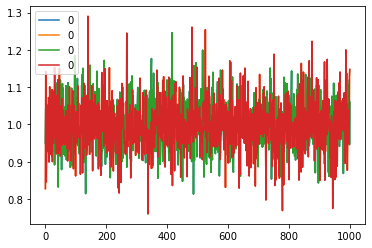

index: 7, sample_mean: 0.00658385781571269 sample_var: 1.0054458379745483, yellow_mean: -0.0010171027388423681 yellow_var: 1.0016701221466064


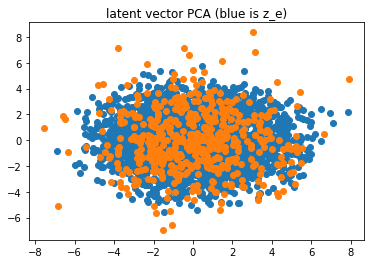

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 7, sample_mean: -0.873826265335083 sample_var: 0.03641499578952789, yellow_mean: -0.8587645292282104 yellow_var: 0.056387610733509064


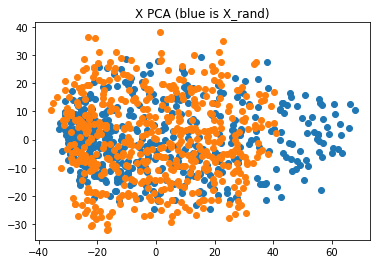

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[8/300] D: 2.98e-10 En: 0.1      De: 0.178   


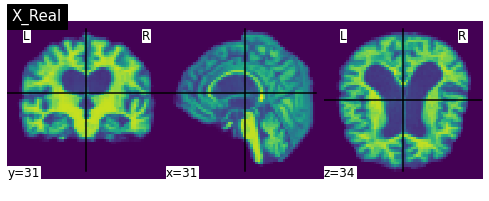

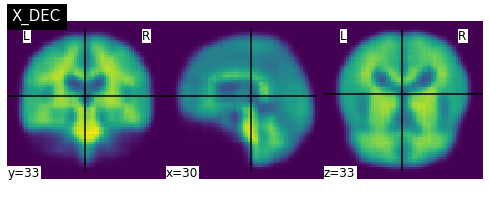

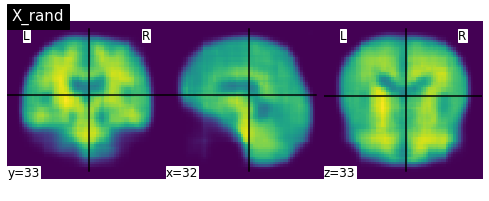

In [ ]:
for epoch in range(init_epoch, N_EPOCH):
    step = 0
    while step < len(train_loader):
        
        real_images = gen_load.__next__().cuda(gpu_0)
        _batch_size = real_images.size(0)
        z_rand = torch.randn((_batch_size, latent_dim), requires_grad=False).cuda(gpu_0)
        ###############################################
        # Train D 
        ###############################################
        for i in range(d_iter):
            d_optimizer.zero_grad()
            mean,logvar,code = E(real_images)
#             code = E(real_images).view(_batch_size,-1).cuda(gpu_0)
            d_real_loss = -D(real_images).mean()
            x_hat = G(code)
            x_rand = G(z_rand)
            
#             gradient_penalty_h = calc_gradient_penalty(D,real_images, x_hat, cuda_ind=gpu_0)
#             gradient_penalty_r = calc_gradient_penalty(D,real_images, x_rand, cuda_ind=gpu_0)
            
            d_recon_loss = D(x_hat).mean()
            d_fake_loss = D(x_rand).mean()

            dis_loss = d_recon_loss+d_real_loss + d_fake_loss# + gradient_penalty_r + gradient_penalty_h
            dis_loss.backward(retain_graph=True)
            d_optimizer.step()
        
        ###############################################
        # Train G
        ###############################################
        g_optimizer.zero_grad()
        
        gen_img_loss = -(d_real_loss + d_recon_loss+ d_fake_loss)
        rec_loss = ((G(code) - real_images)**2).mean()
        
        err_dec = gamma* rec_loss + gen_img_loss
        
        err_dec.backward(retain_graph=True)
        g_optimizer.step()
        ###############################################
        # Train E KL
        ###############################################
        mean,logvar,code = E(real_images)
        prior_loss = 1+logvar-mean.pow(2) - logvar.exp()
        prior_loss = (-0.5*torch.sum(prior_loss))/torch.numel(mean.data)
        err_enc = prior_loss + beta*rec_loss
        ## Train E WL ##############################
#         z_hat = E(real_images).view(_batch_size,-1).cuda(gpu_0)
#         code = z_hat
#         w_dist = sp.sinkhorn_loss(torch.transpose(z_rand, 0, 1), torch.transpose(z_hat, 0, 1), 0.1, 1000, 100, gpu=gpu_0)
#         err_enc = w_dist + beta*rec_loss
        ###############################################
        
        e_optimizer.zero_grad()
        err_enc.backward()
        e_optimizer.step()
        ###############################################
        # Visualization
        ###############################################
        if step % 400 == 0:
            print('[{}/{}]'.format(epoch,N_EPOCH),
                  'D: {:<8.3}'.format(dis_loss.item()), 
                  'En: {:<8.3}'.format(err_enc.item()),
                  'De: {:<8.3}'.format(err_dec.item()) 
                  )
            
            featmask = np.squeeze((0.5*real_images[0]+0.5).data.cpu().numpy())
            featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
            plotting.plot_img(featmask,title="X_Real")
            plotting.show()
            
            featmask = np.squeeze((0.5*G(code)[0]+0.5).data.cpu().numpy())
            featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
            plotting.plot_img(featmask,title="X_DEC")
            plotting.show()
            
            featmask = np.squeeze((0.5*G(z_rand)[0]+0.5).data.cpu().numpy())
            featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
            plotting.plot_img(featmask,title="X_rand")
            plotting.show()

        loss_dict = {
            'd_real_loss': [d_real_loss.item()],
            'd_recon': [d_recon_loss.item()],
            'd_fake': [d_fake_loss.item()],
            'err_enc': [err_enc.item()],
        }
        step += 1
        
    df = add_loss(df, loss_dict)
    write_loss(df, path=pth)
    print(f'G loss: {err_dec.item()}')
    
    viz_pca(E, trainset, latent_size=latent_dim, index=epoch, is_cd=True, gpu_ind=gpu_0, batch_size=4)
    viz_pca(G, trainset, latent_size=latent_dim, index=epoch, gpu_ind=gpu_0, batch_size=4)
    torch.save(G.state_dict(),f'./{pth}/G_VG_ep_'+str(epoch)+'.pth')
    torch.save(D.state_dict(),f'./{pth}/D_VG_ep_'+str(epoch)+'.pth')
    torch.save(E.state_dict(),f'./{pth}/E_VG_ep_'+str(epoch)+'.pth')
    
    

In [ ]:
%debug

In [ ]:
torch.unsqueeze(torch.randn((64, 64, 64)), 1).shape